## Imports

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import datetime
import os
%matplotlib inline

# Force TensorFlow to use CPU only
#tf.config.set_visible_devices([], 'GPU')

# Ensure that TensorFlow doesn't allocate memory on the GPU
#tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('CPU')[0], True)

# Allow memory growth on GPU devices
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
from cycler import cycler

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
#from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard # Callbacks
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, \
                                    Flatten, RandomFlip, RandomRotation,RandomZoom, \
                                    BatchNormalization, Activation # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

# Set mixed precision policy for faster running times
from tensorflow.keras import mixed_precision as mp
mp.set_global_policy("mixed_float16")

2024-03-09 21:34:03.220348: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-09 21:34:03.273350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 21:34:03.273384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 21:34:03.275991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-09 21:34:03.288841: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6


2024-03-09 21:34:06.162703: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-09 21:34:06.196428: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-09 21:34:06.196602: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Plotting results

In [2]:
def plot_history(hs, metric):
    print()
    #plt.style.use('light_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    
    # Set colorblind-friendly colors
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
    
    # Change background to white
    plt.style.use('tableau-colorblind10')

    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    #x_ticks = np.arange(0, epochs + 1, epochs / 10)
    #x_ticks [0] += 1
    #plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

### Cleaning up

In [3]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

### Evaluate all models in folder

In [4]:
def evaluate_models_in_folder(folder_path, X, Y, verbose=1):
    """
    Evaluate all models in the specified folder on the given input data (X) and target data (Y).
    
    Parameters:
        folder_path (str): The path to the folder containing the model files.
        X (numpy.ndarray): The input data.
        Y (numpy.ndarray): The target data.
        verbose (int): Verbosity mode (0 or 1).

    Returns:
        dict: A dictionary containing model filenames as keys and evaluation results as values.
    """
    # Dictionary to store evaluation results
    results = {}
    
    # Get the list of files in the folder
    model_files = [file for file in os.listdir(folder_path) if file.endswith("model.keras")]

    # Iterate over each model file
    for model_file in model_files:
        # Construct the full path to the model file
        model_path = os.path.join(folder_path, model_file)
        
        # Load the model
        model = tf.keras.models.load_model(model_path)
        
        # Evaluate the model on the test data
        evaluation_result = model.evaluate(X, Y, verbose=verbose)
        
        # Store the evaluation result in the dictionary
        results[model_file] = evaluation_result

    # Sort the dictionary by accuracy
    sorted_results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1][1], reverse=True)}

    return sorted_results

# Fashion-MNIST

## Load Fashion-MNIST Data from Tensorflow and preprocess

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Testing images shape: (10000, 28, 28)
Testing labels shape: (10000,)


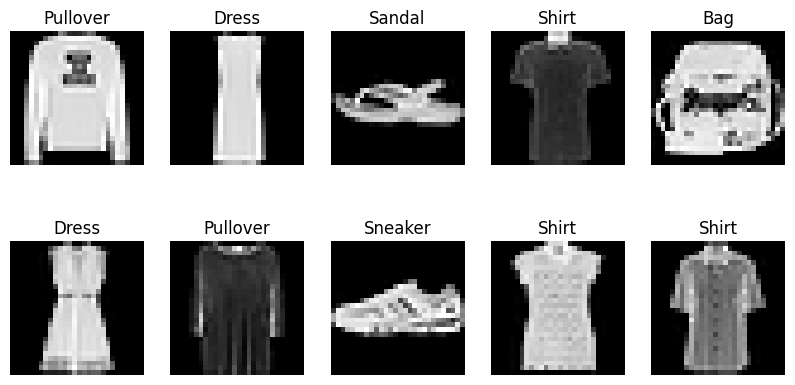

In [6]:
# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Print shapes of the loaded data
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot 10 random examples with their labels
plt.figure(figsize=(10, 5))
for i in range(10):
    idx = np.random.randint(0, train_images.shape[0])
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[idx], cmap='gray')
    plt.title(class_names[train_labels[idx]])
    plt.axis('off')

plt.show()

## MLP

In [15]:
X_train = train_images.reshape(60000, 28*28)/255
X_test = test_images.reshape(10000, 28*28)/255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = to_categorical(train_labels, num_classes= 10)
Y_test = to_categorical(test_labels, num_classes= 10)

In [32]:
def train_model_mlp_fmnist(
        train_data,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=128,
        hidden_layers=0,
        hidden_activation='relu',
        output_activation='softmax',
        dropout_rate = 0.5,
        verbose=1,
        model_path="mlp_fmnist",
        run_name=""
):
    
    np.random.seed(1177) # Define the seed for numpy to have reproducible experiments.
    set_seed(1984) # Define the seed for Tensorflow to have reproducible experiments.

    # Create model directory if it doesn't exist
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    
    # Define the input layer.
    input = Input(
        shape=(28*28,),
        name='Input'
    )

    x = input
    
    # Define the remaining hidden layers.
    for i in range(hidden_layers):
        x = Dense(
            units=256,
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        
    # Add Dropout layer
        x = Dropout(
            rate=dropout_rate,
            name='Dropout-{0:d}'.format(i+1)
        )(x)
        
    # Define the output layer.
    output = Dense(
        units=10,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)

    # Define callbacks list and paths
    log_dir = os.path.join(model_path, "logs",run_name+datetime.datetime.now().strftime("%Y%m%d-%H%M"))

    checkpoint_path = os.path.join(model_path, run_name+"checkpoints.keras")
    
    callbacks_list = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            verbose=1,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
        ),
        TensorBoard(
            log_dir=log_dir,
            histogram_freq = 1,
            profile_batch = '500,520'
        )
    ]
        
            
    # Define the model and train it.
    model = Model(inputs=input, outputs=output, name=model_path)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Print a description of the model.
    model.summary() 
    
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        callbacks=callbacks_list, #callbacks used
        verbose=verbose,
        batch_size=batch_size
        
    )
    print('Finished training.')
    print('------------------')


    # Save the model
    model.save(os.path.join(model_path, run_name+"model.keras"))

    # Save the training history
    with open(os.path.join(model_path, run_name+"history.pkl"), 'wb') as file:
        pickle.dump(hs, file)

    return model, hs


In [36]:
optimizer = Adam() #standard learning rate
optimizer = mp.LossScaleOptimizer(optimizer)

model_path="mlp_fmnist"
run_name="with_dropout0.5_"

# MLP
mlp_model_fmnist, mlp_hs_fmnist = train_model_mlp_fmnist(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=100,
    batch_size=128,
    hidden_layers=3,
    hidden_activation='gelu',
    output_activation='softmax',
    dropout_rate=0.5,
    verbose=1,
    model_path=model_path,
    run_name=run_name
)

Model: "mlp_fmnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Hidden-1 (Dense)            (None, 256)               200960    
                                                                 
 Dropout-1 (Dropout)         (None, 256)               0         
                                                                 
 Hidden-2 (Dense)            (None, 256)               65792     
                                                                 
 Dropout-2 (Dropout)         (None, 256)               0         
                                                                 
 Hidden-3 (Dense)            (None, 256)               65792     
                                                                 
 Dropout-3 (Dropout)         (None, 256)               0

2024-03-09 16:44:18.590538: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-09 16:44:18.590557: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-09 16:44:18.590571: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-09 16:44:18.590574: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-03-09 16:44:18.590576: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-03-09 16:44:18.590579: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1935] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-03-09 16:44:18.590688: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131]

422/422 [==============================] - 2s 4ms/step - loss: 0.7019 - accuracy: 0.7448 - val_loss: 0.4319 - val_accuracy: 0.8427
Epoch 2/100
 98/422 [=====>........................] - ETA: 1s - loss: 0.4873 - accuracy: 0.8233

2024-03-09 16:44:21.409854: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-09 16:44:21.409888: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-09 16:44:21.409905: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-09 16:44:21.409912: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-03-09 16:44:21.409917: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-03-09 16:44:21.409922: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1935] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-03-09 16:44:21.557726: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] 

422/422 [==============================] - 1s 3ms/step - loss: 0.4828 - accuracy: 0.8282 - val_loss: 0.3882 - val_accuracy: 0.8527
Epoch 3/100
422/422 [==============================] - 1s 3ms/step - loss: 0.4406 - accuracy: 0.8429 - val_loss: 0.3615 - val_accuracy: 0.8697
Epoch 4/100
422/422 [==============================] - 1s 3ms/step - loss: 0.4168 - accuracy: 0.8494 - val_loss: 0.3496 - val_accuracy: 0.8717
Epoch 5/100
422/422 [==============================] - 2s 4ms/step - loss: 0.3959 - accuracy: 0.8571 - val_loss: 0.3646 - val_accuracy: 0.8653
Epoch 6/100
422/422 [==============================] - 1s 3ms/step - loss: 0.3921 - accuracy: 0.8595 - val_loss: 0.3400 - val_accuracy: 0.8788
Epoch 7/100
422/422 [==============================] - 1s 3ms/step - loss: 0.3737 - accuracy: 0.8653 - val_loss: 0.3413 - val_accuracy: 0.8748
Epoch 8/100
422/422 [==============================] - 1s 3ms/step - loss: 0.3666 - accuracy: 0.8673 - val_loss: 0.3478 - val_accuracy: 0.8728
Epoch 9/100

313/313 [==============================] - 0s 1ms/step - loss: 0.3207 - accuracy: 0.8892



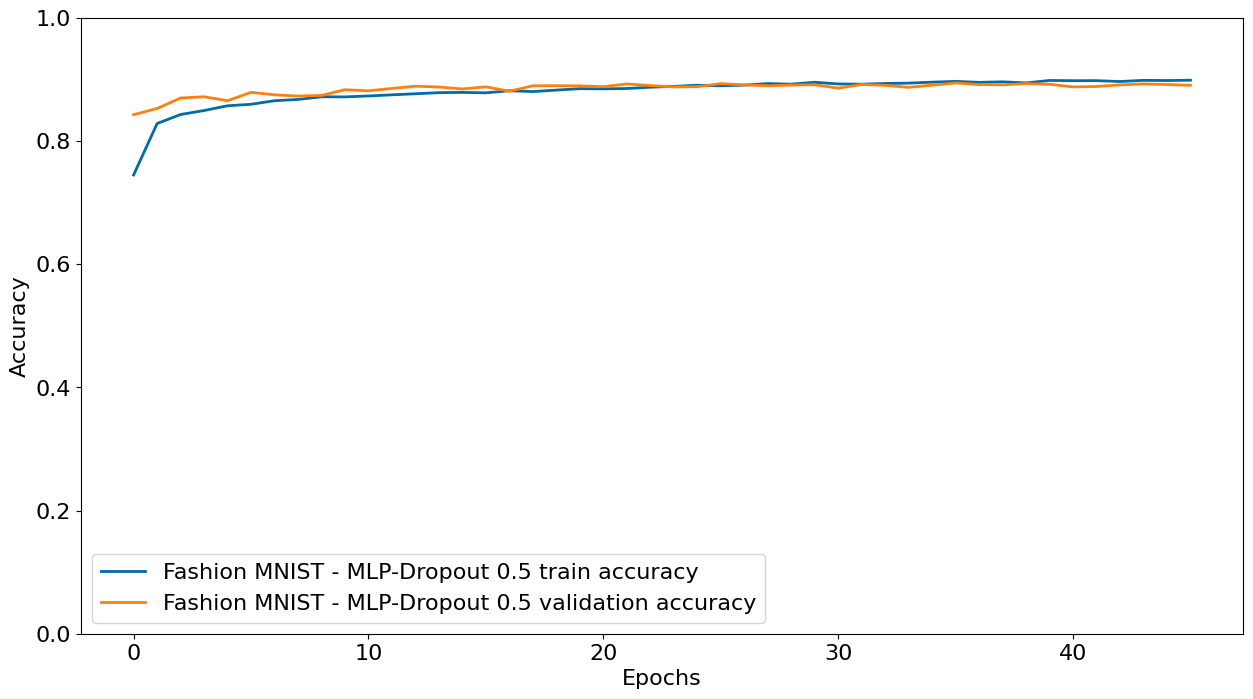

In [37]:
# Load model and evaluate on test data. Show all the results.
model = tf.keras.models.load_model("mlp_fmnist/with_dropout0.5_model.keras")

mlp_eval_fmnist = model.evaluate(X_test, Y_test, verbose=1)

# Load and plot the history
with open('mlp_fmnist/with_dropout0.5_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

plot_history(hs={'Fashion MNIST - MLP-Dropout 0.5': loaded_history}, metric='accuracy')

In [9]:
# physical_devices = tf.config.list_physical_devices('GPU')
# if physical_devices:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

## CNN

In [7]:
# Preprocess the data

X_train = train_images.reshape(60000, 28,28,1)/255
X_test = test_images.reshape(10000, 28,28,1)/255

input_shape = (28,28,1) # 1 channel and 28x28 size
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Y_train = to_categorical(train_labels, num_classes= 10)
Y_test = to_categorical(test_labels, num_classes= 10)

In [11]:
def train_model_cnn_fmnist(
        train_data,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=128,
        data_augmentation=False,
        batch_normalization=False,
        num_filters=8,
        conv_layers=0,
        conv_activation='relu',
        conv_dropout=False,
        dropout_rate=0.2,
        output_activation='softmax',
        verbose=1,
        model_path="cnn_fmnist",
        run_name=""
):
    
    np.random.seed(1177) # Define the seed for numpy to have reproducible experiments.
    set_seed(1984) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Create model directory if it doesn't exist
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    if data_augmentation:
        x = RandomFlip("horizontal")(input)
        x = RandomRotation(0.1)(x)
        x = RandomZoom(0.2)(x)
    else:
        x = input

    
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=num_filters*(2**i),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            use_bias = not batch_normalization,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        
        if batch_normalization: x = BatchNormalization(name='BatchNorm-{0:d}'.format(i + 1))(x)
            
        x = Activation(activation=conv_activation)(x)

        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=dropout_rate,
                name='Conv_Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    x = Dropout(0.2)(x)

    # Add also a Dense layer
    x = Dense(256, name='Dense-{:d}'.format(1))(x)
    x = Dropout(dropout_rate,name='Dense_Dropout-{:d}'.format(1))(x)
    x = Dense(128,name='Dense-{:d}'.format(2))(x)
    x = Dropout(dropout_rate,name='Dense_Dropout-{:d}'.format(2))(x)
    
    # Define the output layer.
    output = Dense(
        units=10,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)

    # Define callbacks list and paths
    log_dir = os.path.join(model_path, "logs",run_name+datetime.datetime.now().strftime("%Y%m%d-%H%M"))

    checkpoint_path = os.path.join(model_path, run_name+"checkpoints.keras")
    
    callbacks_list = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=20,
            verbose=1,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
        ),
        TensorBoard(
            log_dir=log_dir,
            histogram_freq = 1,
            profile_batch = '500,520'
        )
    ]
        
            
    # Define the model and train it.
    model = Model(inputs=input, outputs=output, name=model_path)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Print a description of the model.
    model.summary() 
    
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        callbacks=callbacks_list, #callbacks used
        verbose=verbose,
        batch_size=batch_size
        
    )
    print('Finished training.')
    print('------------------')


    # Save the model
    model.save(os.path.join(model_path, run_name+"model.keras"))

    # Save the training history
    with open(os.path.join(model_path, run_name+"history.pkl"), 'wb') as file:
        pickle.dump(hs, file)

    return model, hs


In [10]:
optimizer = Adam() #standard learning rate
optimizer = mp.LossScaleOptimizer(optimizer)

model_path="cnn_fmnist"
run_name="with_conv_dropout02+2conv+BatchNorm_16filters_"

# CNN
cnn_model_fmnist, cnn_hs_fmnist = train_model_cnn_fmnist(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=100,
    batch_size=64,
    data_augmentation=False,
    num_filters=16,
    conv_layers=2,
    conv_activation='gelu',
    conv_dropout=True,
    batch_normalization=True,
    dropout_rate=0.2,
    output_activation='softmax',
    verbose=1,
    model_path=model_path,
    run_name=run_name
)

Model: "cnn_fmnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 28, 28, 32)        288       
                                                                 
 BatchNorm-1 (BatchNormaliz  (None, 28, 28, 32)        128       
 ation)                                                          
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 32)        0         
                                                                 
 Conv_Dropout-1 (Dropout)    (None, 14, 14, 32)        0         
                                                        

2024-03-09 21:35:55.340543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-09 21:35:55.340804: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-09 21:35:55.340961: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/100


2024-03-09 21:35:58.895483: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


  1/844 [..............................] - ETA: 1:01:43 - loss: 6.7891 - accuracy: 0.1094

2024-03-09 21:36:01.160989: I external/local_xla/xla/service/service.cc:168] XLA service 0x5961d79508a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-09 21:36:01.161010: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-03-09 21:36:01.175102: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710012961.236035 1878086 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


513/844 [=================>............] - ETA: 3s - loss: 1.2313 - accuracy: 0.7577

2024-03-09 21:36:06.202902: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-09 21:36:06.202938: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-09 21:36:06.202956: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-09 21:36:06.202964: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-03-09 21:36:06.202969: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-03-09 21:36:06.202974: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1935] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-03-09 21:36:06.384015: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] 

541/844 [==================>...........] - ETA: 3s - loss: 1.2045 - accuracy: 0.7595

2024-03-09 21:36:06.413820: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-03-09 21:36:06.425268: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: cnn_fmnist/logs/with_conv_dropout02+4conv+BatchNorm_20240309-2135/plugins/profile/2024_03_09_21_36_06/etheleigh.xplane.pb


844/844 [==============================] - 13s 11ms/step - loss: 0.9867 - accuracy: 0.7813 - val_loss: 0.3736 - val_accuracy: 0.8695
Epoch 2/100
844/844 [==============================] - 8s 9ms/step - loss: 0.4588 - accuracy: 0.8455 - val_loss: 0.3346 - val_accuracy: 0.8770
Epoch 3/100
844/844 [==============================] - 8s 9ms/step - loss: 0.3682 - accuracy: 0.8704 - val_loss: 0.2963 - val_accuracy: 0.8937
Epoch 4/100
844/844 [==============================] - 8s 9ms/step - loss: 0.3358 - accuracy: 0.8811 - val_loss: 0.2778 - val_accuracy: 0.8997
Epoch 5/100
844/844 [==============================] - 8s 9ms/step - loss: 0.3152 - accuracy: 0.8881 - val_loss: 0.3053 - val_accuracy: 0.8877
Epoch 6/100
844/844 [==============================] - 7s 9ms/step - loss: 0.2998 - accuracy: 0.8924 - val_loss: 0.3284 - val_accuracy: 0.8785
Epoch 7/100
844/844 [==============================] - 8s 9ms/step - loss: 0.2911 - accuracy: 0.8956 - val_loss: 0.3053 - val_accuracy: 0.8907
Epoch 8/1

In [12]:
cnn_model_fmnist.evaluate(X_test, Y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.2341 - accuracy: 0.9184


[0.234099879860878, 0.91839998960495]

In [133]:
# Evaluate all models
sorted_results = evaluate_models_in_folder("cnn_fmnist", X_test, Y_test, verbose=0)
for model_file, evaluation_result in sorted_results.items():
    print(f"Model: {model_file}, Accuracy: {evaluation_result[1]:.4f}")

Model: with_conv_dropout02+4conv+BatchNorm_model.keras, Accuracy: 0.9110
Model: with_conv_dropout_5conv_model.keras, Accuracy: 0.9109
Model: with_conv_dropout_4conv_model.keras, Accuracy: 0.9089
Model: with_conv_dropout02+8conv_model.keras, Accuracy: 0.9087
Model: with_conv_dropout_3convmodel.keras, Accuracy: 0.9071
Model: with_conv_dropout_4conv_moreDensemodel.keras, Accuracy: 0.9054
Model: with_conv_dropout_3conv_relumodel.keras, Accuracy: 0.9025
Model: with_conv_dropout_2convmodel.keras, Accuracy: 0.9011
Model: with_conv_dropout_3conv_model.keras, Accuracy: 0.8997
Model: with_conv_dropout_3conv_v2_model.keras, Accuracy: 0.8977
Model: with_conv_dropout+8conv+data_aug_model.keras, Accuracy: 0.8713
Model: with_conv_dropout+5conv+data_aug_model.keras, Accuracy: 0.8502


In [135]:
tf.keras.backend.clear_session()

In [136]:
model = tf.keras.models.load_model("cnn_fmnist/with_conv_dropout02+4conv+BatchNorm_model.keras")

model.summary()

model.evaluate(X_test, Y_test, verbose=1)

Model: "cnn_fmnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 28, 28, 8)         72        
                                                                 
 BatchNorm-1 (BatchNormaliz  (None, 28, 28, 8)         32        
 ation)                                                          
                                                                 
 activation (Activation)     (None, 28, 28, 8)         0         
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 8)         0         
                                                                 
 Conv_Dropout-1 (Dropout)    (None, 14, 14, 8)         0         
                                                        

[0.24400225281715393, 0.9110000133514404]

In [137]:
# # Load model and evaluate on test data. Show all the results.
# model = tf.keras.models.load_model("cnn_fmnist/with_conv_dropout_4conv_model.keras")

# model.evaluate(X_test, Y_test, verbose=1)

# # Load and plot the history
# with open('cnn_fmnist/with_conv_dropout_3convhistory.pkl', 'rb') as file:
#     hs_3cv = pickle.load(file)

# with open('cnn_fmnist/with_conv_dropout_4conv_history.pkl', 'rb') as file:
#     hs_4cv = pickle.load(file)


    
# plot_history(hs={'Fashion MNIST - CNN-Dropout 0.2 - 3 Conv': hs_3cv,
#                  'Fashion MNIST - CNN-Dropout 0.2 - 4 Conv_relu': hs_4cv
#                 }, metric='accuracy')

# CIFAR10

## Loading CIFAR10 Data from Tensorflow

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing images shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


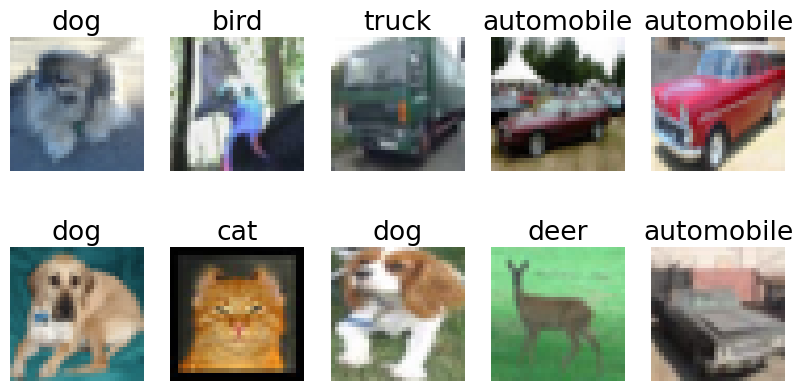

In [11]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Print shapes of the loaded data
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot 10 random examples with their labels
plt.figure(figsize=(10, 5))
for i in range(10):
    idx = np.random.randint(0, train_images.shape[0])
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[idx])
    plt.title(class_names[train_labels[idx][0]])
    plt.axis('off')
plt.show()

### MLP

### CNN

In [12]:
# import wandb
# wandb.login()
# run = wandb.init(project="jupyter-projo",
#                  config={"batch_size": 128,
#                          "learning_rate": 0.01,
#                          "dataset": "CIFAR-10"})

In [13]:
# import time

# for ii in range(30):
#   wandb.log({"acc": 1 - 2 ** -ii, "loss": 2 ** -ii})
#   time.sleep(0.5)

In [14]:
# if wandb.run is not None:
#   wandb.finish()